# Rule Trends - by Location
## Buisness Question: Do purchases vary by destination location?
Andrew Reichel



List:
- MBA All Trans

TODO:
- MBA All Returns

### Configure libraries and load dataset (previously aggregated into csv from discrete xlsx)

In [17]:
import pandas as pd
import numpy as np
import sys, os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

''' setup paths '''
data_dir = '../data/'

for doc in os.listdir(data_dir):
    if doc.endswith('csv'):
        df_0911 = pd.read_csv(os.path.join(data_dir,doc),index_col=0)
df_0911.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [18]:
df_0911.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### Establish frunctions to prep data and mine rules

In [19]:
def cleanup_df(df_in):
    ''' clean up DESCRIPTION col of df_in to:
            1. remove spaces
            2. drop rows w/o invoice numbers
            3. drop postage row
            4. remove returned transactions (C) '''
    # drop extra spaces
    df_in.loc[:,'Description'] = df_in.loc[:,'Description'].str.strip()
    # drop rows w/o invoice number
    #df_in.dropna(axis=0, subset=['Invoice'], inplace=True)
    df_in.loc[:,'Invoice'] = df_in.loc[:,'Invoice'].astype(str)
    # drop postage row
    #df_in = df_in.Description.drop('POSTAGE', axis = 0)
    # drop Invoice == 'C' rows
    df_in = df_in[~df_in.loc[:,'Invoice'].str.contains('C')]
    
    return df_in

def encode_purch(item):
    ''' set all instances of purchase to 1, else == 0
        drop postage column '''
    if item >= 1:
        return 1
    else:
        return 0

def make_basket(df_in):
    ''' setup basket for MBA 
            1. One Hot Encode transactions 
            2. '''
    df_cleaned = cleanup_df(df_in)
    basket = (df_cleaned.groupby(['Invoice','Description'])['Quantity']
              .sum().unstack().reset_index().fillna(0).set_index('Invoice'))
    
    basket = basket.applymap(encode_purch)
    #print basket.POSTAGE
    if 'POSTAGE' in basket.columns:
        basket = basket.drop('POSTAGE', axis = 1)
    return basket

def mine_rules(country, min_supp = 'NA', verbose = False):  
    ''' function to extract rules or perform min_supp sensitivity test if no
        min_supp is provided '''
    # find orders by country
    df_country = df_0911[df_0911.Country == country]
    
    # make baskets
    baskets = make_basket(df_country)
    print "len of basket: ",len(baskets)
    
    ''' if min_supp not given, run sensitivity test on minsupp, else find
        all association rules '''
    if min_supp == 'NA':
        items = {}
        for min_sup in np.linspace(0.41, 0.02, 35):
            frq_itms = apriori(baskets, min_support=min_sup, use_colnames=True)
            items[min_sup] = len(frq_itms)
            if verbose == True:
                print "Considering Min_Supp: {}: {}".format(min_sup, len(frq_itms))
        freq_items = pd.DataFrame.from_dict(items, orient='index')
        return items
    else:
        freq_items = apriori(baskets, min_support=min_supp, use_colnames=True)
        rules = association_rules(freq_items, metric='confidence', min_threshold=0.35)
        return rules


### Test on USA Orders 

In [20]:
df_USorders = df_0911[df_0911.Country == 'USA']
print "US Orders: ", len(df_USorders.Invoice.unique())
df_USorders.head()

US Orders:  25


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,141.00,12636.0,USA
51589,494110,21268,VINTAGE BLUE TINSEL REEL,24,2010-01-11 12:29:00,2.10,12549.0,USA
51590,494110,21412,VINTAGE GOLD TINSEL REEL,11,2010-01-11 12:29:00,0.42,12549.0,USA
51591,494110,22083,PAPER CHAIN KIT RETRO SPOT,6,2010-01-11 12:29:00,2.95,12549.0,USA
51592,494110,22084,PAPER CHAIN KIT EMPIRE,6,2010-01-11 12:29:00,2.95,12549.0,USA


In [21]:
print make_basket(df_USorders).shape
baskets = make_basket(df_USorders)
baskets.head()

(20, 303)


Description,12 PENCILS SMALL TUBE RED RETROSPOT,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 DOILIES SPACEBOY DESIGN,5 HOOK HANGER MAGIC TOADSTOOL,5 HOOK HANGER RED MAGIC TOADSTOOL,6 GIFT TAGS 50'S CHRISTMAS,6 GIFT TAGS VINTAGE CHRISTMAS,60 CAKE CASES DOLLY GIRL DESIGN,...,VINTAGE UNION JACK BUNTING,VINTAGE UNION JACK SHOPPING BAG,WOOD STAMP SET BEST WISHES,WOODLAND DESIGN COTTON TOTE BAG,WRAP CHRISTMAS VILLAGE,WRAP COWBOYS,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP I LOVE LONDON,WRAP WEDDING DAY
Invoice,,,,,,,,,,,,,,,,,,,,,
489444,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494891,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0


(0.42, 0.04)

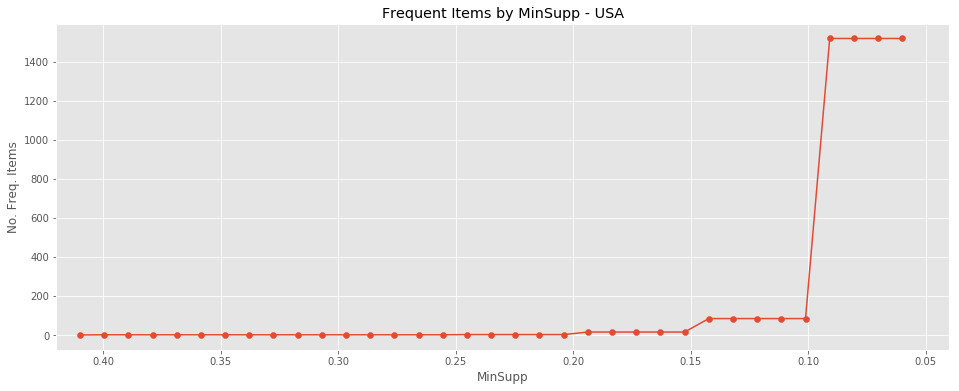

In [22]:
''' find minsupp sensitivity '''
items = {}
for min_sup in np.linspace(0.41, 0.06, 35):
    #print "Considering Min_Supp: ", min_sup
    frq_itms = apriori(baskets, min_support=min_sup, use_colnames=True)
    items[min_sup] = len(frq_itms)

freq_items = pd.DataFrame.from_dict(items, orient='index')

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
ax.set_title('Frequent Items by MinSupp - USA')
ax.set_xlabel('MinSupp')
ax.set_ylabel('No. Freq. Items')
ax.scatter(freq_items.index, freq_items.iloc[:,0])
ax.plot(freq_items.sort_index())
ax.set_xlim(0.42, 0.04)

### Find ideal min_supp, by country

In [23]:
print "Unique Countries in Data: {}".format(len(df_0911.Country.unique()))

country_ords = {}
for country in df_0911.Country.unique():
    tmp = df_0911[df_0911.Country == country]
    #print country, len(tmp)
    country_ords[country] = len(tmp.Invoice.unique())

df_ords_Country = pd.DataFrame.from_dict(country_ords, orient='index',columns=['Order Count'])

Unique Countries in Data: 43


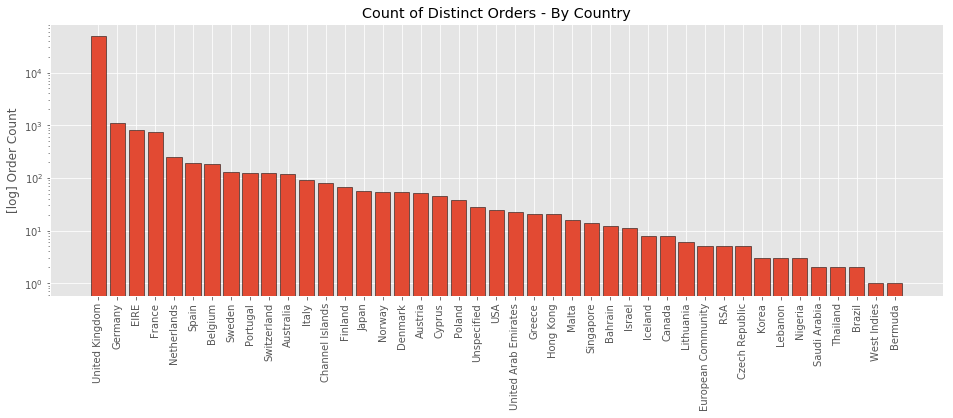

In [24]:
''' plot of Order Count by Country '''
plt.style.use('ggplot')
df_ords_Country = df_ords_Country.sort_values(['Order Count'], axis=0, ascending=False)
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
ax.set_title('Count of Distinct Orders - By Country')
ax.set_ylabel('[log] Order Count')
ax.bar(df_ords_Country.index,df_ords_Country['Order Count'],edgecolor='black')
plt.yscale('log')
plt.xticks(rotation = 90);

### Identify Top 5 countries for rule mining

In [25]:
df_ords_Country = df_ords_Country.sort_values(by=['Order Count'], axis=0, ascending=False)
top_countries = df_ords_Country.index[:20]

Use uniform min_supp

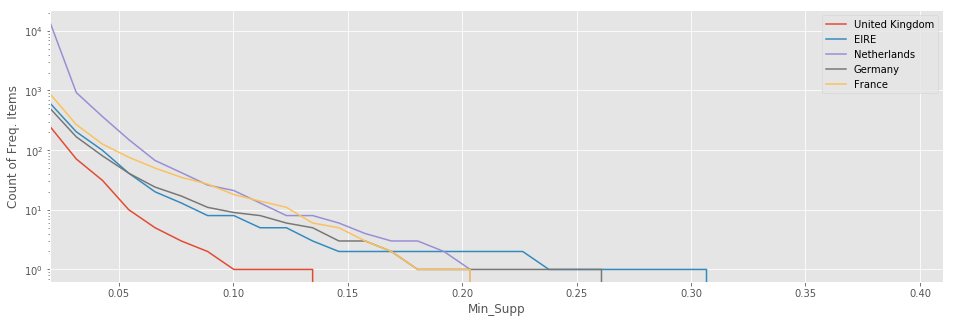

In [26]:
''' plot of freq items by min supp '''
min_sup_df = pd.read_csv('../results/freq_item_count.csv', index_col=0)

fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
ax.set_xlabel('Min_Supp')
ax.set_ylabel('Count of Freq. Items')
min_sup_df.sort_index().plot(figsize = (16,5), ax=ax)
plt.yscale('log')

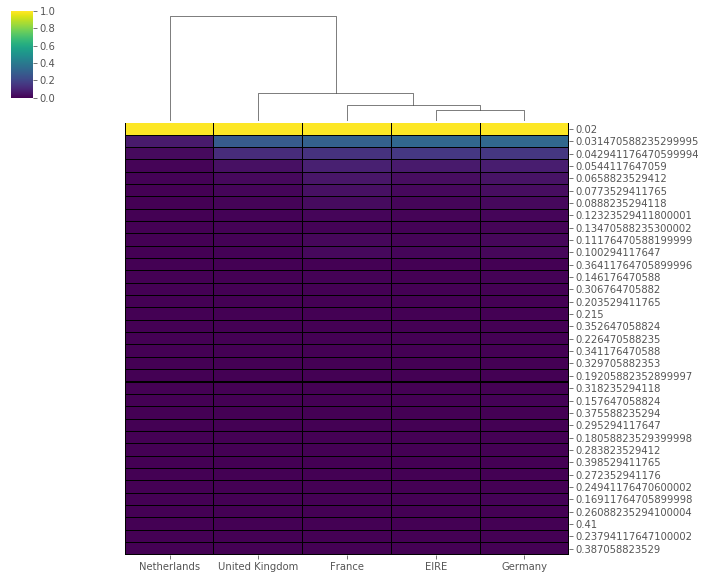

In [27]:
sns.clustermap(min_sup_df,standard_scale=1, row_cluster=False, cmap = 'viridis', 
               linewidth=0.005, linecolor='black');

In [28]:
frq_items = {}

for country in top_countries:
    print country
    country_df = df_0911[df_0911.Country == country]
    country_df_sparse = make_basket(country_df)
    country_frqItems = apriori(country_df_sparse, min_support=0.1, use_colnames=True)
    print "Frequent Items: {}".format(len(country_frqItems))
    item_set_len = []
    for i in country_frqItems.itemsets:
        item_set_len.append(len(i))
    country_frqItems['set_len'] = item_set_len
    
    # write to frq_items
    frq_items[country] = country_frqItems 
    print "max length of freq itemset: ",country_frqItems.set_len.max()

United Kingdom
Frequent Items: 1
max length of freq itemset:  1
Germany
Frequent Items: 9
max length of freq itemset:  2
EIRE
Frequent Items: 8
max length of freq itemset:  1
France
Frequent Items: 18
max length of freq itemset:  2
Netherlands
Frequent Items: 21
max length of freq itemset:  2
Spain
Frequent Items: 5
max length of freq itemset:  1
Belgium
Frequent Items: 24
max length of freq itemset:  3
Sweden
Frequent Items: 5
max length of freq itemset:  1
Portugal
Frequent Items: 25
max length of freq itemset:  2
Switzerland
Frequent Items: 32
max length of freq itemset:  3
Australia
Frequent Items: 5
max length of freq itemset:  1
Italy
Frequent Items: 20
max length of freq itemset:  2
Channel Islands
Frequent Items: 47
max length of freq itemset:  3
Finland
Frequent Items: 11
max length of freq itemset:  2
Japan
Frequent Items: 24
max length of freq itemset:  3
Norway
Frequent Items: 65
max length of freq itemset:  3
Denmark
Frequent Items: 31
max length of freq itemset:  3
Austri

In [29]:
''' create Itemset dict'''
item_count = {}
for country in frq_items:
    for itemset in frq_items[country].itemsets:
        item_count[str(itemset)] = 0
for country in frq_items:
    for itemset in frq_items[country].itemsets:
        item_count[str(itemset)] += 1

In [30]:
frq_df = pd.DataFrame.from_dict(item_count, orient='index', columns=['Count']).reset_index()

frq_df.sort_values('Count', ascending=False)

,index,Count
539,['RED TOADSTOOL LED NIGHT LIGHT'],10
675,['REGENCY CAKESTAND 3 TIER'],10
194,['ROUND SNACK BOXES SET OF 4 FRUITS'],8
171,['WHITE HANGING HEART T-LIGHT HOLDER'],7
224,['PLASTERS IN TIN WOODLAND ANIMALS'],7
262,['ROUND SNACK BOXES SET OF4 WOODLAND'],7
7,['PLASTERS IN TIN CIRCUS PARADE'],7
759,['SPACEBOY LUNCH BOX'],6
747,['PLASTERS IN TIN SPACEBOY'],6
375,"['ROUND SNACK BOXES SET OF 4 FRUITS', 'ROUND S...",5


In [33]:
frq_df.Count

0      1
1      2
2      1
3      2
4      1
5      1
6      1
7      7
8      1
9      1
10     1
11     1
12     1
13     1
14     1
15     1
16     1
17     1
18     1
19     3
20     1
21     1
22     1
23     1
24     1
25     1
26     1
27     1
28     1
29     1
      ..
819    1
820    1
821    1
822    1
823    1
824    1
825    1
826    1
827    1
828    1
829    1
830    1
831    4
832    1
833    1
834    1
835    1
836    1
837    1
838    1
839    1
840    1
841    1
842    1
843    1
844    1
845    1
846    1
847    1
848    1
Name: Count, Length: 849, dtype: int64

In [34]:
''' create sparse matrix of freq items by country'''
freqItems_Country = pd.DataFrame()
for country in frq_items:
    itemsets = []
    tmp_df = pd.DataFrame()
    print country
    tmp = frq_items[country]
    for i in tmp.itemsets:
        itemsets.append(str(i))
    tmp_df['itemset'] = itemsets
    tmp_df['country'] = [country]*len(tmp)
    
    freqItems_Country = pd.concat([freqItems_Country,tmp_df],axis=0)

EIRE
Netherlands
Italy
Portugal
Denmark
Poland
Finland
Channel Islands
Austria
France
United Kingdom
Switzerland
Sweden
Australia
Germany
Belgium
Japan
Cyprus
Norway
Spain


In [35]:
cols = freqItems_Country.itemset.unique()

encode_dict = {}
for country in freqItems_Country.country.unique():
    print country
    is_present = []
    tmp = freqItems_Country[freqItems_Country.country == country]
    for i in cols:
        if i in tmp.itemset.values:
            is_present.append(1)
        else: is_present.append(0)
    encode_dict[country] = is_present
    
freq_df = pd.DataFrame.from_dict(encode_dict, orient='index')
freq_df.columns = cols

freq_df

EIRE
Netherlands
Italy
Portugal
Denmark
Poland
Finland
Channel Islands
Austria
France
United Kingdom
Switzerland
Sweden
Australia
Germany
Belgium
Japan
Cyprus
Norway
Spain


,['60 TEATIME FAIRY CAKE CASES'],['BAKING SET 9 PIECE RETROSPOT'],['CARRIAGE'],['PACK OF 60 PINK PAISLEY CAKE CASES'],['REGENCY CAKESTAND 3 TIER'],['ROSES REGENCY TEACUP AND SAUCER'],['VINTAGE SNAP CARDS'],['WHITE HANGING HEART T-LIGHT HOLDER'],['DOLLY GIRL LUNCH BOX'],['FOLKART ZINC HEART CHRISTMAS DEC'],...,"['PACK OF 72 SKULL CAKE CASES', 'PINK HEART SHAPE EGG FRYING PAN']","['PLASTERS IN TIN SPACEBOY', 'PLASTERS IN TIN VINTAGE PAISLEY']","['RECIPE BOX BLUE SKETCHBOOK DESIGN', 'RECIPE BOX PANTRY YELLOW DESIGN']","['RECIPE BOX PANTRY YELLOW DESIGN', 'RECIPE BOX RETROSPOT']","['REGENCY CAKESTAND 3 TIER', 'SET OF 3 CAKE TINS PANTRY DESIGN']","['SET OF 3 CAKE TINS PANTRY DESIGN', 'SET OF TEA COFFEE SUGAR TINS PANTRY']","['BLACK KITCHEN SCALES', 'BREAD BIN DINER STYLE IVORY', 'IVORY KITCHEN SCALES']","['CHILDS BREAKFAST SET DOLLY GIRL', 'CHILDS BREAKFAST SET SPACEBOY', 'RED TOADSTOOL LED NIGHT LIGHT']","['COOK WITH WINE METAL SIGN', 'PACK OF 72 SKULL CAKE CASES', 'PINK HEART SHAPE EGG FRYING PAN']","['HOT WATER BOTTLE TEA AND SYMPATHY', 'RECIPE BOX PANTRY YELLOW DESIGN', 'RECIPE BOX RETROSPOT']"
EIRE,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Netherlands,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Italy,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Portugal,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Norway,0,0,0,1,1,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
Denmark,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Poland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Finland,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Channel Islands,1,0,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Sweden,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


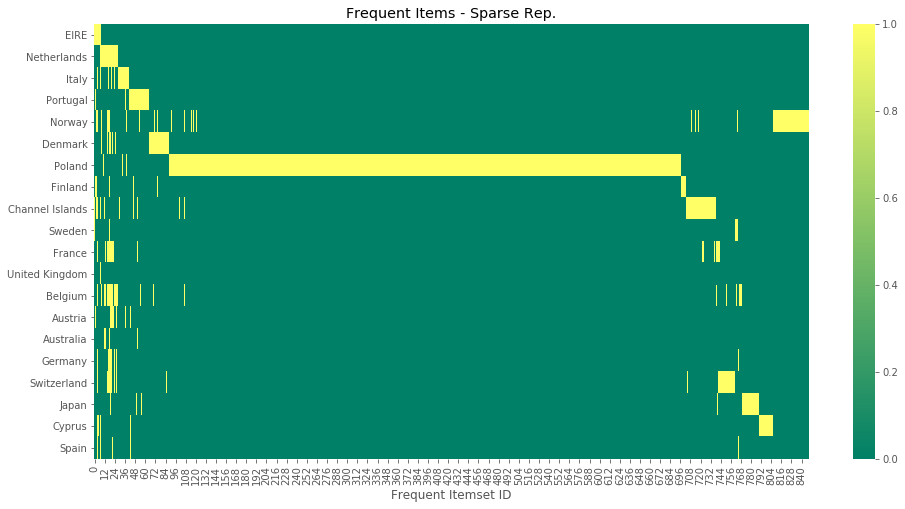

In [36]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
sns.heatmap(freq_df.T.reset_index(drop=1).T, cmap='summer')#, linewidth=.01, linecolor='black')
ax.set_xlabel('Frequent Itemset ID')
ax.set_title('Frequent Items - Sparse Rep.')
plt.xticks(rotation='90');

<Figure size 1152x576 with 0 Axes>

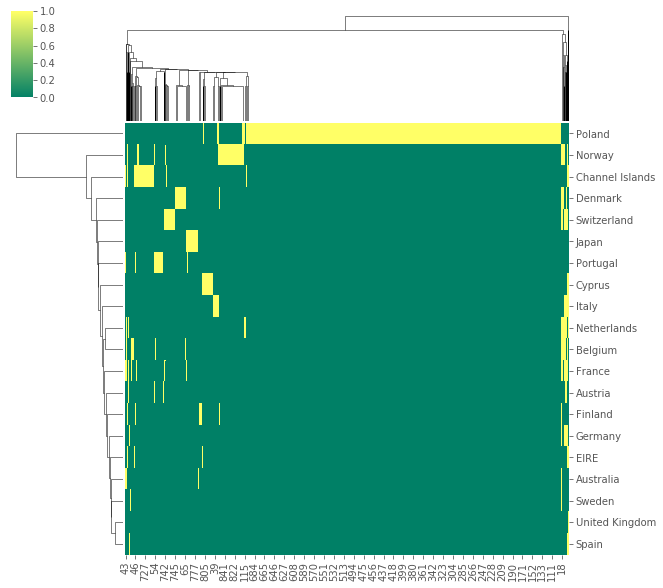

In [37]:
fig = plt.figure(figsize=(16,8))
sns.clustermap(freq_df.T.reset_index(drop=1).T, cmap='summer')#, linewidth=.01, linecolor='black');
plt.title=('Test')

### Drop Poland to improve vis for report

In [38]:
cols = freqItems_Country.set_index('country').drop('Poland').itemset.unique()

encode_dict = {}
for country in freqItems_Country.country.unique():
    if country not in ['Poland']:
        print country
        is_present = []
        tmp = freqItems_Country[freqItems_Country.country == country]
        for i in cols:
            if i in tmp.itemset.values:
                is_present.append(1)
            else: is_present.append(0)
        encode_dict[country] = is_present
    
freq_df = pd.DataFrame.from_dict(encode_dict, orient='index')
freq_df.columns = cols

freq_df.to_csv('/Users/areichel/Documents/Personals/DS5230/DS5500_ChangeMining/data/frqItemset_Country_20200330.csv')

EIRE
Netherlands
Italy
Portugal
Denmark
Finland
Channel Islands
Austria
France
United Kingdom
Switzerland
Sweden
Australia
Germany
Belgium
Japan
Cyprus
Norway
Spain


,['60 TEATIME FAIRY CAKE CASES'],['BAKING SET 9 PIECE RETROSPOT'],['CARRIAGE'],['PACK OF 60 PINK PAISLEY CAKE CASES'],['REGENCY CAKESTAND 3 TIER'],['ROSES REGENCY TEACUP AND SAUCER'],['VINTAGE SNAP CARDS'],['WHITE HANGING HEART T-LIGHT HOLDER'],['DOLLY GIRL LUNCH BOX'],['FOLKART ZINC HEART CHRISTMAS DEC'],...,"['PACK OF 72 SKULL CAKE CASES', 'PINK HEART SHAPE EGG FRYING PAN']","['PLASTERS IN TIN SPACEBOY', 'PLASTERS IN TIN VINTAGE PAISLEY']","['RECIPE BOX BLUE SKETCHBOOK DESIGN', 'RECIPE BOX PANTRY YELLOW DESIGN']","['RECIPE BOX PANTRY YELLOW DESIGN', 'RECIPE BOX RETROSPOT']","['REGENCY CAKESTAND 3 TIER', 'SET OF 3 CAKE TINS PANTRY DESIGN']","['SET OF 3 CAKE TINS PANTRY DESIGN', 'SET OF TEA COFFEE SUGAR TINS PANTRY']","['BLACK KITCHEN SCALES', 'BREAD BIN DINER STYLE IVORY', 'IVORY KITCHEN SCALES']","['CHILDS BREAKFAST SET DOLLY GIRL', 'CHILDS BREAKFAST SET SPACEBOY', 'RED TOADSTOOL LED NIGHT LIGHT']","['COOK WITH WINE METAL SIGN', 'PACK OF 72 SKULL CAKE CASES', 'PINK HEART SHAPE EGG FRYING PAN']","['HOT WATER BOTTLE TEA AND SYMPATHY', 'RECIPE BOX PANTRY YELLOW DESIGN', 'RECIPE BOX RETROSPOT']"
EIRE,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Netherlands,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Italy,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Portugal,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Norway,0,0,0,1,1,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
Denmark,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Finland,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Channel Islands,1,0,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Sweden,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
France,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


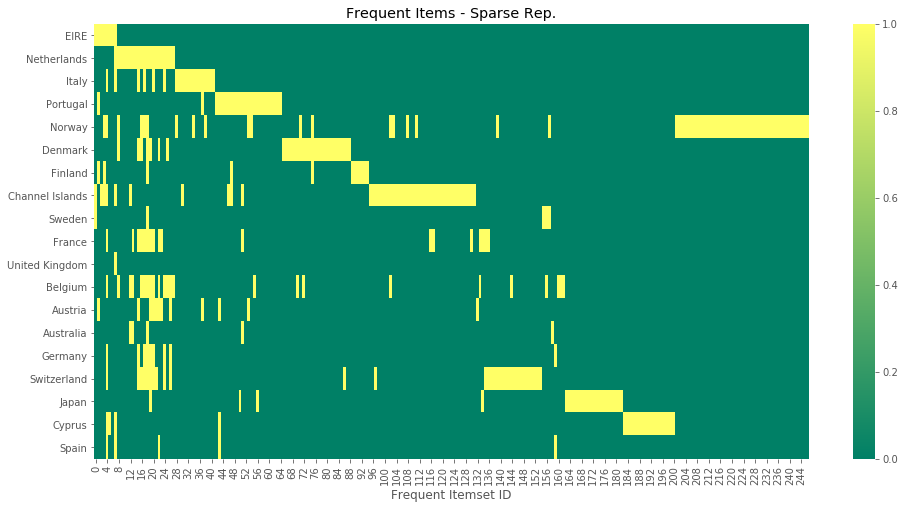

In [39]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
sns.heatmap(freq_df.T.reset_index(drop=1).T, cmap='summer')#, linewidth=.01, linecolor='black')
ax.set_xlabel('Frequent Itemset ID')
ax.set_title('Frequent Items - Sparse Rep.')
plt.xticks(rotation='90');

<Figure size 1152x576 with 0 Axes>

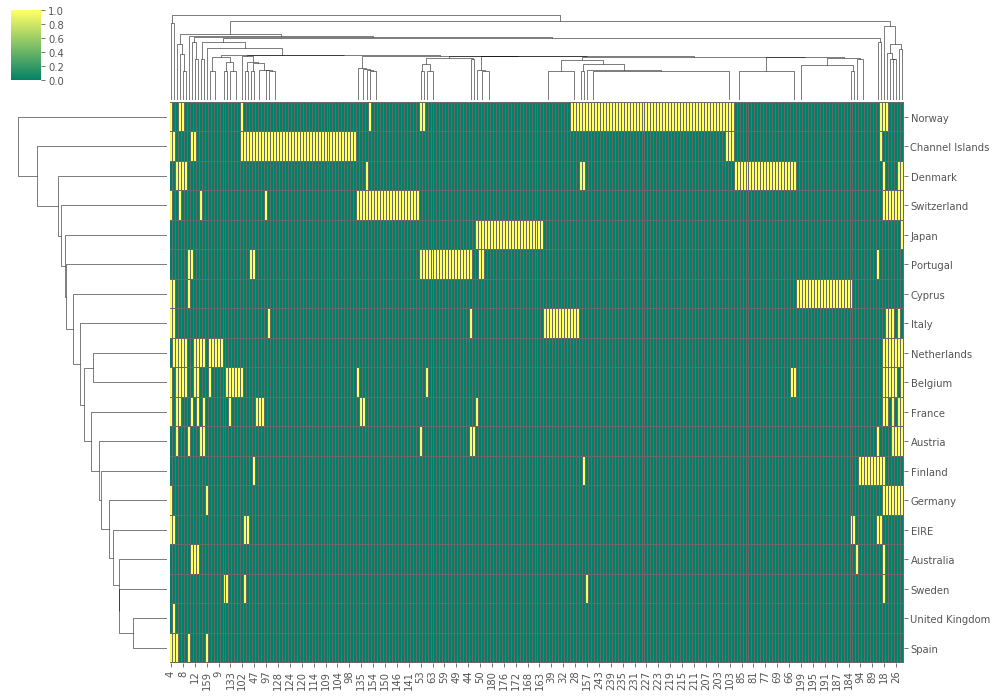

In [40]:
fig = plt.figure(figsize=(16,8))
sns.clustermap(freq_df.T.reset_index(drop=1).T, cmap='summer',figsize=(16,12),linewidth=.005, linecolor='dimgrey');
plt.title=('Test')